In [134]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product

path = 'C:/Users/lingj/Documents/Personal/Career/Interview/Apple/App Store Data Scientist/'


%matplotlib inline

In [2]:
con = sqlite3.connect(path+'sqlite3/main.db')
data = pd.read_sql('select * from transaction_dat_enr;', con)

In [27]:
tmp = data.groupby('txn_create_dt')['txn_price'].sum()
# tmp.to_excel(path+'/output/3_time_series_prediction_y.xlsx')

Check if there is any missing date or data inconsistency

In [32]:
set(pd.date_range(tmp.index[0], tmp.index[-1], freq='D')) - set(pd.to_datetime(tmp.index))

{Timestamp('2016-08-22 00:00:00', freq='D'),
 Timestamp('2016-08-23 00:00:00', freq='D'),
 Timestamp('2016-08-24 00:00:00', freq='D')}

In [128]:
y_train = tmp.loc[:'2016-08-21']

<AxesSubplot:xlabel='txn_create_dt'>

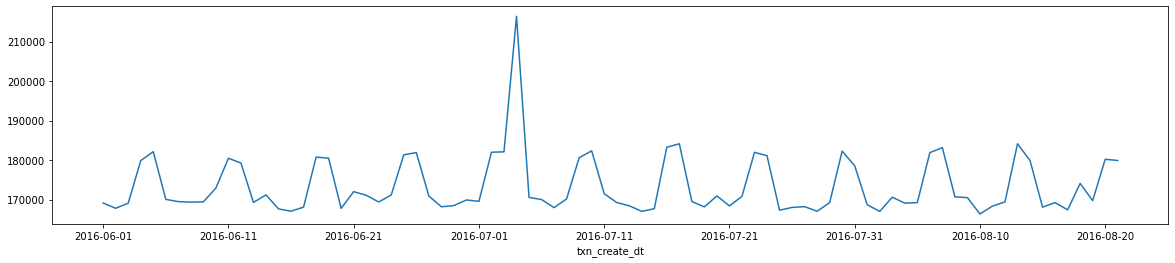

In [129]:
y_train.plot(figsize=(20,4))

Need to remove the data for week of July 4th as holiday outlier. 2016-07-04 is Monday. Considering pre and momentum effect, I will remove the data from the Friday before July 4th to the Thursday of the holiday. 

In [130]:
y_train = pd.Series(y_train[:'2016-06-30'].values.tolist() + y_train['2016-07-08':].values.tolist())

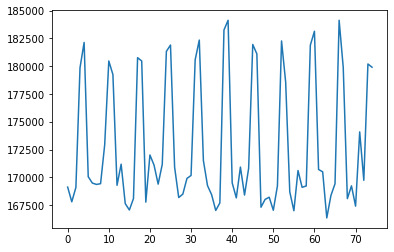

In [131]:
plt.plot(y_train)

# Stationarity Test, Augmented Dickey-Fuller Test

In [132]:
print('p-value for the original series: {}'.format(adfuller(y_train)[1]))

p-value for the original series: 0.004551646054723067


The original series is stationary. No need for difference. 

C:\Users\lingj\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


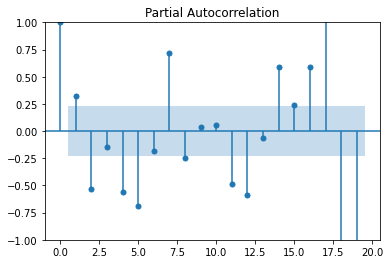

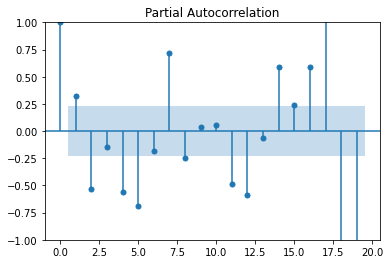

In [133]:
# AR(p)
plot_pacf(y_train)

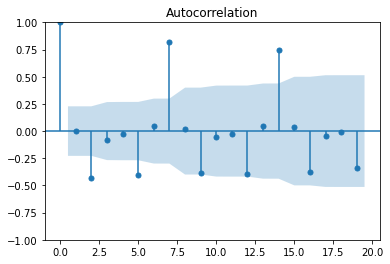

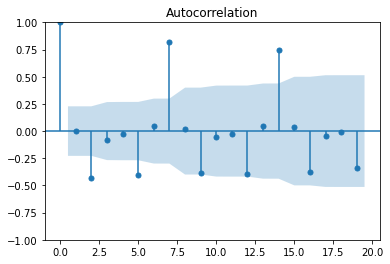

In [109]:
# MA(q)
plot_acf(y_train)

In [151]:
p = range(1, 3)
q = range(1, 3)
P = range(1, 3)
Q = range(1, 3)
params_list = list(product(p, q, P, Q))

In [152]:
# order=(p, d, q)
bic_list = []
for params in tqdm(params_list):
    mdl = ARIMA(y_train, order=(params[0], 0, params[1]), seasonal_order=(params[2], 0, params[3], 7)).fit()
    bic_list.append(mdl.bic)

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]C:\Users\lingj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  6%|█████▏                                                                             | 1/16 [00:00<00:05,  2.95it/s]C:\Users\lingj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 12%|██████████▍                                                                        | 2/16 [00:00<00:05,  2.59it/s]C:\Users\lingj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Like

In [155]:
bic_ser = pd.Series(bic_list, index=params_list)
bic_ser.sort_values(ascending=False)

(2, 1, 2, 2)    1460.136334
(1, 1, 2, 2)    1459.189885
(2, 2, 2, 2)    1419.049518
(1, 2, 2, 2)    1408.121844
(2, 1, 2, 1)    1402.695298
(2, 2, 1, 2)    1390.203654
(2, 1, 1, 2)    1389.739347
(2, 2, 2, 1)    1384.536208
(2, 2, 1, 1)    1382.625360
(2, 1, 1, 1)    1381.383993
(1, 1, 1, 2)    1381.356120
(1, 2, 1, 2)    1379.669569
(1, 2, 2, 1)    1379.421800
(1, 1, 2, 1)    1377.960616
(1, 2, 1, 1)    1376.301059
(1, 1, 1, 1)    1371.631083
dtype: float64

In [156]:
mdl = ARIMA(y_train, order=(2, 0, 1), seasonal_order=(2, 0, 2, 7)).fit()

C:\Users\lingj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [168]:
periods=100
y_hat = mdl.predict(start=0, end=periods-1)
date_range = pd.date_range(tmp.index[0], periods=periods, freq='D') 
y_hat.index = date_range

In [169]:
date_range = pd.date_range(tmp.index[0], periods=y_train.shape[0], freq='D')
y_train_ser = pd.Series(y_train.values, date_range)

<AxesSubplot:>

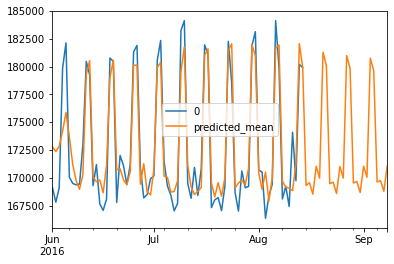

In [170]:
df = pd.concat([y_train_ser, y_hat], axis=1)
df.plot()

In [171]:
df.to_excel(path+'/output/3_time_series_prediction_yhat.xlsx')

In [24]:
data

,acct_id,acct_create_dt,acct_type,txn_create_dt,txn_content_id,txn_price,txn_device_id,txn_device_name,txn_type,app_id,app_name,app_category_id,app_category_name,app_device_id,app_device_name
0,220574a7a6a71afa,2009-08-29,PMOF,2016-08-28,b6cf4f33e7455df4,11.99,1,iPhone,subscription,61cea77b9bc843d1,events Bildad's,M-7,Utilities,3,Both
1,8551f69a5015ea6a,2011-05-28,PMOF,2016-09-16,71ac3e9c38ddbbba,1.99,2,iPad,consumable,1f0ebd67df5846cd,swell questionably,M-7,Utilities,3,Both
2,7dedf309494a1966,2009-11-15,PMOF,2016-08-15,776b851b916c33d1,0.99,2,iPad,consumable,1383e4f2f49f0f44,supperless--my Shipmates,Z-1,Games,2,iPad
3,7174a81c796dcf7e,2009-03-01,PMOF,2016-06-17,7a47ca132a8dc695,1.99,2,iPad,consumable,8590a25d4e5c249c,unwritten hungry,Z-1,Games,2,iPad
4,35aaf59d64a677e7,2010-10-01,PMOF,2016-06-13,30581219bc952dbb,11.99,2,iPad,consumable,478e10f9248b7842,Turning thanked,Q-1,Entertainment,3,Both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3607504,a269f5917d3da8e7,2010-07-12,PMOF,2016-09-21,0ceab364ddb9372d,0.00,1,iPhone,None,0ceab364ddb9372d,profoundest who,Z-1,Games,1,iPhone
3607505,32c5446c52bbfd21,2010-09-05,PMOF,2016-09-21,0ceab364ddb9372d,0.00,1,iPhone,None,0ceab364ddb9372d,profoundest who,Z-1,Games,1,iPhone
3607506,8834fcbfe20e1dfe,2012-01-01,PMOF,2016-09-21,0ceab364ddb9372d,0.00,1,iPhone,None,0ceab364ddb9372d,profoundest who,Z-1,Games,1,iPhone
3607507,929a102def7c93a4,2009-09-24,PMOF,2016-09-21,0ceab364ddb9372d,0.00,1,iPhone,None,0ceab364ddb9372d,profoundest who,Z-1,Games,1,iPhone
